# Naive Bayes Classification on Amazon Fine Food Reviews DataSet:

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

##### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

###### Number of reviews: 568,454
###### Number of users: 256,059
###### Number of products: 74,258
###### Timespan: Oct 1999 - Oct 2012
###### Number of Attributes/Columns in data: 10

###### Attribute Information:

###### Id - Id of the row in the dataset
###### ProductId - unique identifier for the product
###### UserId - unqiue identifier for the user
###### ProfileName - name on the profile
###### HelpfulnessNumerator - number of users who found the review helpful
###### HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
###### Score - rating between 1 and 5
###### Time - timestamp for the review
###### Summary - brief summary of the review
###### Text - text of the review
###### Objective:
######  To apply the Naive Bayes classifier on the Bow , TF-IDF Vectors and computing the Test Accuracy for each Vectors and finding the top words (both negative and positive predicted using the Log Probabilities)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

import sqlite3
import string
import nltk

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from tqdm import tqdm

from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# ============================== data preprocessing ===========================================
# Making the connection to the database.sqlite
con = sqlite3.connect("C:\\Users\\Ashu\\Desktop\\AAIC\\IPython Notebooks\\AMAZON Fine Food Reviews\\amazon-fine-food-reviews\\database.sqlite")





In [2]:
# Extracting out the positive and negative features 
amazon_featured_reviews = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3""" , con)

print(amazon_featured_reviews.shape)




# Creating the partition function returning the positive or negative reviews and appending them in the Score column in place 
# of ratings given:

def partition(x):
        if x < 3:
            return 'negative'
        else :
            return 'positive'
        
        
pos_neg_reviews_df = amazon_featured_reviews['Score'].map(partition)
print(type(pos_neg_reviews_df) , 'pos_neg_reviews_df' , pos_neg_reviews_df.shape)
print('type(amazon_featured_reviews):' , type(amazon_featured_reviews))
amazon_featured_reviews['Score'] = pos_neg_reviews_df
amazon_featured_reviews.shape
amazon_featured_reviews.head(2)


(525814, 10)
<class 'pandas.core.series.Series'> pos_neg_reviews_df (525814,)
type(amazon_featured_reviews): <class 'pandas.core.frame.DataFrame'>


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [3]:
# Data deduplication is used to clean the data having redundancy and many unwanted things which msut be removed to further
# use the data:

duplicate_df = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE !=3 AND Text IN 
                                    (SELECT Text FROM REVIEWS
                                    GROUP BY Text having count(*) > 1)
                                    """ , con)
duplicate_df.head(4)

#So we can see there are many such duplicated rows having some column values similar to each other

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
1,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
2,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
3,70,B000E7VI7S,AWCBF2ZWIN57F,C. Salcido,0,2,5,1185753600,pretzel haven!,this was sooooo deliscious but too bad i ate e...


In [4]:
#Doing some other check using the below query to see whether such reduncdancy is over small scale or a large scale of rows:
# From count(*) values we can see that we have so much of redundant data, so it has to be cleaned.
dup_data = pd.read_sql_query("""
select ID,ProductID,USERID , PROFILENAME , Summary ,text ,count(*) AS COUNT
FROM REVIEWS
GROUP BY PRODUCTID,SUMMARY,TEXT  
having count(*) > 1""",con)
dup_data.head(6)

,Id,ProductId,UserId,ProfileName,Summary,Text,COUNT
0,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
1,217385,7310172101,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
2,369857,B000084DWM,A3TVZM3ZIXG8YW,christopher hayes,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",10
3,369801,B000084DWM,A36JDIN9RAAIEC,Jon,"Great product, but trust your vet not the hype","I have two cats, one 6 and one 2 years old. Bo...",2
4,410265,B000084EZ4,A2FGXWWR8ZU59C,Thomas Lawrence,"Cats love the food, but no pull-tab top, and d...","I appreciate being able to buy this larger, mo...",2
5,410304,B000084EZ4,A29JUMRL1US6YP,HTBK,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,4


In [5]:
# Let's see another case:

dup_data = pd.read_sql_query("""SELECT * FROM REVIEWS
                                    WHERE SCORE != 3 AND UserId = "AJD41FBJD9010" AND ProductID="7310172001"
                                    Order by ProductID""" , con)
dup_data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,171152,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,dogs LOVE it-- best treat for rewards and tra...,Freeze dried liver has a hypnotic effect on do...
1,171153,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
2,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
3,171189,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",39,51,5,1233360000,NO waste at all ---- great for training ----...,Freeze dried liver has a hypnotic effect on do...
4,171223,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
5,171228,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",5,7,5,1233360000,NO waste at all--- all dogs love liver treats-...,Freeze dried liver has a hypnotic effect on do...


# Observation:

####    In above Analysis what we found is :
###### There are product's having the same productID's with same {'TEXT'} , {'Timestamp'} , {'UserID'}
###### There are products having the different productID's with same {'TEXT'} , {'Timestamp'} , {"helpfullnessNumerator"} , {"HelpfullnessNumerator"} 
##### We termed such type of the data in our data set as Redundant Data , so we perform various cleaning methods to remove them from
###### the Data Set.

In [6]:
#Removing the Duplicate data points:

duplicated_data = amazon_featured_reviews.duplicated(subset={'UserId','ProfileName','Time','Summary','Text'} , keep='first')
duplicated_data = pd.DataFrame(duplicated_data , columns=['Boolean'])
print(duplicated_data.head(5))

#True values in the Boolean Series represents the duplicate data:
print(duplicated_data['Boolean'].value_counts(dropna=False)) #gives me the total no of the duplicates

#The total no of duplicates here in the amazon_featured_reviews are:
print("total no of duplicates here in the amazon_featured_reviews are:",duplicated_data[duplicated_data['Boolean']==True].count())

#dropping the duplicates:
final = amazon_featured_reviews.sort_values(by='ProductId',kind='quicksort',ascending=True,inplace=False)
final = final.drop_duplicates(subset={'UserId','ProfileName','Time','Text'} , keep='first', inplace=False)
print('\n','DataFrame final shape before removing helpfullness data :', final.shape)

#Also removing the instances where HelpfulnessNumerator >= HelpfulnessDenominator:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('final', final.shape)


   Boolean
0    False
1    False
2    False
3    False
4    False
False    365333
True     160481
Name: Boolean, dtype: int64
total no of duplicates here in the amazon_featured_reviews are: Boolean    160481
dtype: int64

 DataFrame final shape before removing helpfullness data : (364173, 10)
final (364171, 10)


In [7]:
#Finding the books data in the amazon_featured_reviews using the regex:
import re
print(final.columns)
def analyzing_summary_book(filtered_data , regex):
    
    mask_summary = filtered_data.Summary.str.lower().str.contains(regex) 
    mask_text =    filtered_data.Text.str.lower().str.contains(regex)
    print(len(filtered_data[mask_summary].index) , len(filtered_data[mask_text].index))
    print('initial shape of the filtered_data' , filtered_data.shape)
    filtered_data.drop(filtered_data[mask_summary].index , inplace=True , axis=0)
    filtered_data.drop(filtered_data[mask_text].index , axis=0 , inplace=True)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [8]:
#Removing the Books reviews we get below final dataframe:
#On observation of some of the reviews we got certain keywords related to books,reading ,poems , story,learn , study , music 
#So we removed these words as much as possible:


print('final shape before removing books reviews:' , final.shape)
analyzing_summary_book(final , re.compile(r'reading|books|book|read|study|learn|poems|music|story'))

print('final shape after removing the book reviews:' , final.shape)

final shape before removing books reviews: (364171, 10)
2842 36649
initial shape of the filtered_data (364171, 10)
final shape after removing the book reviews: (326808, 10)


In [9]:
#Computing the proportion of positive and negative class labels in the DataFrame:
final['Score'].value_counts()

positive    276668
negative     50140
Name: Score, dtype: int64

In [10]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
print(stop)
print('\n' , 'length of stopwords set' , len(stop))

print("*" * 30)

sno = SnowballStemmer('english')

{'again', 'aren', 'with', 'too', 'under', 'mightn', 'until', 'between', 'up', 'because', "didn't", 'am', 'that', 'where', 'both', 'isn', 'an', 'had', 'these', "couldn't", 'him', 'a', 'doing', 'such', 'now', 'hadn', 'herself', "hasn't", 's', 'she', 'above', 'were', 'from', 'very', 'than', "you'd", "that'll", 'whom', 'if', 'over', "isn't", "shouldn't", 'his', 'while', 'here', "mightn't", 'no', 'd', 'those', "mustn't", 'own', "doesn't", "she's", 'only', 'do', 'her', "hadn't", "should've", 'it', 'our', 'few', 'my', 'down', 'll', 'the', 'weren', 'all', "you've", 'other', 't', 'them', 'o', 'hasn', 'about', 'once', 'how', 'mustn', 'themselves', 'ourselves', 'of', "weren't", 'more', 'in', 'yours', 'yourself', 'me', 'don', 'ours', 'does', 'yourselves', "don't", 'most', "you'll", 'be', 'to', 'your', 'himself', 'for', 'each', 'myself', 'we', 'at', 'not', 'against', 'will', 'haven', 'did', 'are', 'after', 'being', 'needn', 'just', 'off', 'shouldn', 'this', "shan't", 'why', 'what', 'itself', 'is', 

# Observation:
#### We found many redundancy in the data set and some of the Books data which does not make any sense here.
##### We dropped the almost 160K records in data de duplication step.

# Text Preprocessing : 
### Removing Removing html tags
### Removing Punctuation charcaters
### Alphanumeric numbers 
### Length of words must be > 2  
### Uppercase to Lowercase
### Removing the stop words
### Using the Snowball Stemmer.  

In [11]:
# Functions to clean the html tags and punctuation marks using Regular Expression.

def clean_htmlTags(sentence):
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern , '' , sentence)
    return cleaned_text

def clean_punc(sentence):
    cleaned = re.sub(r'[!|#|,|?|\'|"]' , r' ' , sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]' ,r' ' , cleaned)
    return cleaned


In [13]:
#The below code will remove all the html tags , punctuation marks , uppercase to lowercase conversion only if length of the words
# are greater than 2 and are alphanumeric . Further we perform the Stemming of the each word in the each document.

all_positive_words = []
all_negative_words = []
i = 0
str_temp = ' '
final_string = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = clean_htmlTags(sent)
    for w in sent.split():
        for clean_word in clean_punc(w).split():
            if((clean_word.isalpha()) and (len(clean_word) > 2)):
                if(clean_word.lower() not in stop):
                    s = (sno.stem(clean_word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if((final['Score'].values)[i] == 'positive'):
                        all_positive_words.append(s)
                    if((final['Score'].values)[i] == 'negative'):
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue

    str_temp = b" ".join(filtered_sentence)
    final_string.append(str_temp)
    i+=1

In [18]:
#Now I have a final_string of list of each review and append it to the new columns of the final data frame:

final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')
final.shape


(326808, 11)

In [19]:
#Making backup of th pre processed data for the future use:
#final_backup = final

In [155]:

final_backup.shape #to use the dataframe in future if required

(326808, 11)

In [482]:
#Now lets take roughly same proportion of  each of positive and negative review from the data set for faster processing 
#the further data:
#We can process our next tasks with whole amount of the data but we are bounded with time and memory spaces so we have used


# To sample 250K points :

final_clean = final.iloc[:250000,:]
print(final_clean.shape)
print(final_clean['Score'].value_counts())


(250000, 11)
positive    212553
negative     37447
Name: Score, dtype: int64


In [483]:
#Sort the final data frame by timestamp values:
final_clean['Time'] = pd.to_datetime(final['Time'],unit='s')
final_clean = final_clean.sort_values(by='Time')
final_clean.shape

(250000, 11)

#### BAG OF WORDS:


In [484]:
#Now we will compute Naive Bayes
#According to the assignment requirement we have to use cross validation techinque to find the optimal value of alpha.


def Naive_Bayes_GridSearchCV(X_train , y_train):
    
    #creating the odd list of nearest neighbors values:
    alpha_vals = list(np.arange(10e-6 , 10e-2 , 0.005))
    
    cv_scores=[]
    
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(alpha=alpha_vals)
    print(param_grid)
    
    # instantiate the grid
    naive = MultinomialNB()
    
    grid = GridSearchCV(naive, param_grid, cv=8, scoring='accuracy', return_train_score=False)
    
    # fit the grid with data
    grid.fit(X_train, y_train)
    
    # array of mean scores 
    cv_scores = [result.mean_validation_score for result in grid.grid_scores_]
    #print(cv_scores)
    
    
    # The below code will give the tuned parameter and the best mean accuracy among K-fold CV:
    optimal_alpha = grid.best_params_['alpha']
    
    Naive_Bayes_plot_CV_error(cv_scores , alpha_vals)
    
    print('*'*80)
    # examine the best model
    print('Best Score among all the alpha values is:' , grid.best_score_)
    print('Grid_best_params:' , grid.best_params_)
    print('Grid_best_estimator:' , grid.best_estimator_)
    
    return optimal_alpha
    
               
    
        
    
        

In [485]:
# Below function plot the Cross validation error versus the K values taken by us and we graphically compute our best K but
# we can have the idea of the rough value of K from the plot.

def Naive_Bayes_plot_CV_error(cv_scores , neighbors):
    
    # Computing the CV_error and plotting them against the K values in neighbors list:
    
    MSE = [1-x for x in cv_scores]
        
    # Plotting the misclassification error and the corresponding K-vaule:
    # We will consider that K value which has low error
    plt.figure(figsize=(8,8))
    plt.plot(neighbors , MSE , linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    
    for xy in zip(neighbors , np.round(MSE , 3)):
        plt.annotate('(%s,%s)' % xy , xy=xy ,textcoords='data')
    plt.title('CV_error Vs Alpha value')
    plt.xlabel('Alpha values')
    plt.ylabel('CV_error error')
    plt.show()

In [486]:
# ============================== KNN with k = optimal_k_value ===============================================
# instantiate learning model k = optimal_k_value
#Test the optimal value of K to predict the new query point from the X_test:


def Naive_Bayes_optimal_confusion_matrix_plot(X_train , y_train , X_test , optimal_alpha , Vectorizer_type):

  naive_optimal = MultinomialNB(alpha=optimal_alpha)

  # fitting the model
  naive_optimal.fit(X_train, y_train)

  # predict the response
  
  pred_test = naive_optimal.predict(X_test)

  # evaluate accuracy
  
  acc_test = accuracy_score(y_test, pred_test)

  
  print('\nThe accuracy score of the Naive Classifier on Test Data for alpha = %f is %f' % (optimal_alpha, acc_test))
  
  print('*'*100)

  #Now Lets represent the predicted and actual values of class labels by our model:
  #Since our data is imbalanced data set we will use the confusion_matrix to check the accuracy of our model:

  cm = confusion_matrix(y_test , pred_test)
  print("Confusion Matrix for the " , Vectorizer_type , ':\n' , cm)

  print('*'*100)
  # plotting the confusion matrix to describe the performance of our classifier.
  print("Plotting the Confusion Matrix:")
  class_label = ["negative", "positive"]
  df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
  sns.heatmap(df_cm, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()
    
  print('*'*100)
  
  # To show the main classification report:
  from sklearn.metrics import classification_report
  print ('\n The Clasification report for','MultinomialNB',' algorithm with alpha =',optimal_alpha,' is \n ' , classification_report(y_test,pred_test))

In [487]:
# This method will take log probabilites of the each word and frame them in the dataframe for each class in the dataset.

def top_10_features(optimal_alpha , count_vect , X_train , Vectorizer):
    NB_optimal = MultinomialNB()
    NB_optimal.fit(X_train , y_train)
    features = count_vect.get_feature_names()
    df = pd.DataFrame(NB_optimal.feature_log_prob_,columns=features)
    df_new = df.T
    print('Feature Importance for the ' , Vectorizer)
    
    # Computing the negative and positive features log_porbabilities and taking only first 10 high probabilites:
    neg_features = df_new[0].sort_values(ascending = False)[0:10] 
    pos_features = df_new[1].sort_values(ascending = False)[0:10] 
    return pos_features , neg_features

In [488]:
# Creating the training data :
X = final_clean['CleanedText']
y = final_clean['Score']
print(X.shape , y.shape)


(250000,) (250000,)


In [489]:
#Now we will split our train and test data and convert them to the Bag of words vector:
X_train, X_test , y_train , y_test = train_test_split(X , y , test_size=0.3 , random_state=40)
print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)


(175000,) (75000,) (175000,) (75000,)


In [490]:
# Computing the Train Vectorizer :
count_vect = CountVectorizer(ngram_range=(1,1) , min_df=5)
X_train_bow = count_vect.fit_transform(X_train)
print(X_train_bow.shape)
type(X_train_bow)

(175000, 13999)


scipy.sparse.csr.csr_matrix

In [491]:
#Computing the Test Vectorizer:
X_test_bow = count_vect.transform(X_test)
print(X_test_bow.shape)
type(X_test_bow)

(75000, 13999)


scipy.sparse.csr.csr_matrix

In [499]:
# Below is the vocabulary dataframe of each word in Bag of words vector with its log probabilities.
NB_optimal = MultinomialNB()
NB_optimal.fit(X_train_bow , y_train)
features = count_vect.get_feature_names()
df = pd.DataFrame(NB_optimal.feature_log_prob_ , columns=features)
df_new = df.T
df_new.head()


,0,1
aaah,-13.748574,-13.313115
aafco,-12.139137,-12.559343
aah,-13.748574,-13.600797
aback,-11.956815,-12.619968
abandon,-11.445989,-11.781638


{'alpha': [1e-05, 0.00501, 0.01001, 0.015009999999999999, 0.02001, 0.02501, 0.03001, 0.035010000000000006, 0.040010000000000004, 0.04501, 0.050010000000000006, 0.05501, 0.06001, 0.06501, 0.07001, 0.07501, 0.08001, 0.08501, 0.09000999999999999, 0.09501]}


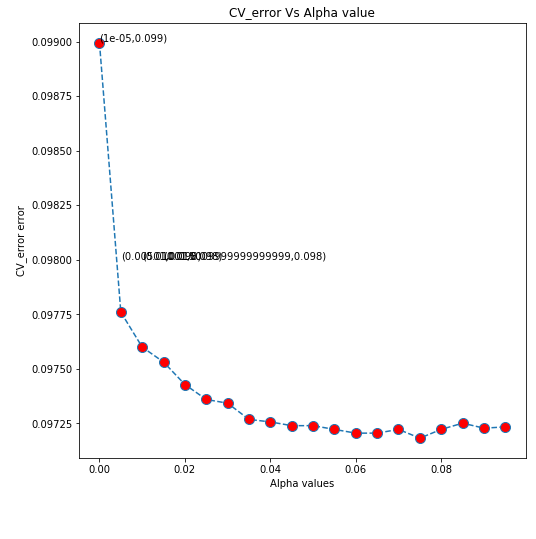

********************************************************************************
Best Score among all the alpha values is: 0.9028171428571429
Grid_best_params: {'alpha': 0.07501}
Grid_best_estimator: MultinomialNB(alpha=0.07501, class_prior=None, fit_prior=True)
Optimal Value for alpha is: 0.07501
****************************************************************************************************

The accuracy score of the Naive Classifier on Test Data for alpha = 0.075010 is 0.902240
****************************************************************************************************
Confusion Matrix for the  Bag_of_Words :
 [[ 7779  3464]
 [ 3868 59889]]
****************************************************************************************************
Plotting the Confusion Matrix:


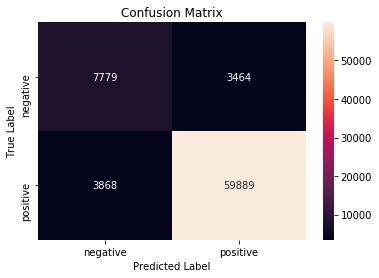

****************************************************************************************************

 The Clasification report for MultinomialNB  algorithm with alpha = 0.07501  is 
               precision    recall  f1-score   support

   negative       0.67      0.69      0.68     11243
   positive       0.95      0.94      0.94     63757

avg / total       0.90      0.90      0.90     75000

Feature Importance for the  Bag-of-Words


In [502]:

#Optimal value for MultinomialNB:
optimal_alpha = Naive_Bayes_GridSearchCV(X_train_bow, y_train)
print('Optimal Value for alpha is:' , optimal_alpha)

print('*'*100)

#Plotting the Confusion matrix for the predicted and actual values to check the accuracy of our model:
#The Naive_Bayes_optimal_confusion_matrix_plot function takes 5 arguments as follows:
#<X_train , y_train , X_test , optimal_value_of_alpha , type_of_vector>
#This method finds the average accuracy score of Naive Bayes model on our test data set.
#This method also computes the final Confusion Matrix which determines the performance of our model.
#We have calculated the classification report for the classifier Naive Bayes.

Naive_Bayes_optimal_confusion_matrix_plot(X_train_bow , y_train ,X_test_bow , optimal_alpha ,'Bag_of_Words')

#Calculating the top_10_features for the positive reviews and negative reviews:
pos_features , neg_features = top_10_features(optimal_alpha , count_vect ,X_train_bow ,  'Bag-of-Words')


In [503]:
print("Top 10 positive words with high probability")
pos_features

Top 10 positive words with high probability


like      -4.403339
tast      -4.459235
love      -4.553662
good      -4.566895
great     -4.596743
flavor    -4.616563
use       -4.678361
tea       -4.746227
one       -4.746489
product   -4.791058
Name: 1, dtype: float64

In [504]:
print('*'*80)
print("Top 10 negative words with high probability")
neg_features

********************************************************************************
Top 10 negative words with high probability


tast      -4.157472
like      -4.264321
product   -4.365458
one       -4.693135
flavor    -4.750932
tri       -4.858991
would     -4.859818
good      -5.008878
use       -5.020958
buy       -5.048227
Name: 0, dtype: float64

#### Terminology

##### true positives (TP): We predicted +ve review, and review is also +ve.
##### true negatives (TN): We predicted -ve, and review is also -ve.
##### false positives (FP): We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.")
##### false negatives (FN): We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")

# OBSERVATION(BoW):

##### 1)  In case of Bag of Words vector using the GRIDSEARCHCV() we got the best parametet i.e alpha value 0.07501 and the best accuracy score on Cross Validation data as 0.9028171428571429 which is so much precise. We computed the accuracy score on Test Data as 0.902240 which is near about the accuracy of our model.

##### 2) From the confusion matrix let's define the TP , TN , FP , FN:
#####     Here TP = 59889 which means 59889 predicted positive reviews  we correctly classified as positive.
#####     TN = 7779, FN = 3868 , FP = 3464
##### 3) Classification Rate/Accuracy:
###### Accuracy = (TP + TN) / (TP + TN + FP + FN)=(59889+7779/(59889+7779+3868+3464)) = 67668/75000 = 0.9022 , which is equal to our accuracy of our classifieras stated above.

###### Recall: Recall gives us an idea about when it’s actually yes, how often does it predict yes.
###### Recall=TP / (TP + FN)=0.90

###### Precision: Precsion tells us about when it predicts yes, how often is it correct.
###### Precision = TP / (TP + FP)=0.90

###### High recall, low precision:This means that most of the positive examples are correctly recognized (low FN) but there are a lot of false positives.

##### TPR : TPR is equal to the precision value so TPR = 0.90
##### TNR : TNR = TN/(TN + FP) = 7779/(7779+3464) = 0.69
##### FPR : FPR = FP/(FP+TN) = 3464/(7779+3464) = 0.30
##### FNR : FNR = FN/(TP+FN) = 3868/(3868+59889) = 0.060

##### We get low values of FPR and FNR relatively so our model is sensible.
 

In [505]:
#Now we will split our train and test data and convert them to the TF - idf  vector:
X_train, X_test , y_train , y_test = train_test_split(X , y , test_size=0.3 , random_state=55)
print(X_train.shape , y_train.shape , X_test.shape , y_test.shape)

(175000,) (175000,) (75000,) (75000,)


# Naive Bayes for the TF-idf vector using Train and Test Data:

In [506]:
#Uni Gram  Train dataset Tf-IDF Vector:
tfidf_vector = TfidfVectorizer(ngram_range=(1,2) , min_df=5 )
X_train_tfidf= tfidf_vector.fit_transform(X_train)

print('X_train_tfidf.get_shape() : ' , X_train_tfidf.get_shape())


# Uni Gram Test dataset Tf-IDF Vectorizer:
X_test_tfidf= tfidf_vector.transform(X_test)

print('X_test_tfidf.get_shape():' , X_test_tfidf.shape)




X_train_tfidf.get_shape() :  (175000, 189587)
X_test_tfidf.get_shape(): (75000, 189587)


In [507]:
# Below is the vocabulary dataframe of each word in Bag of words vector with its log probabilities.
NB_optimal = MultinomialNB()
NB_optimal.fit(X_train_tfidf , y_train)
features = tfidf_vector.get_feature_names()
df = pd.DataFrame(NB_optimal.feature_log_prob_ , columns=features)
df_new = df.T
df_new.head()


,0,1
aaah,-12.764596,-13.210115
aafco,-12.660749,-13.013757
aah,-12.764596,-13.186570
aback,-12.166547,-12.702003
abandon,-12.062453,-12.101976


{'alpha': [1e-05, 0.00501, 0.01001, 0.015009999999999999, 0.02001, 0.02501, 0.03001, 0.035010000000000006, 0.040010000000000004, 0.04501, 0.050010000000000006, 0.05501, 0.06001, 0.06501, 0.07001, 0.07501, 0.08001, 0.08501, 0.09000999999999999, 0.09501]}


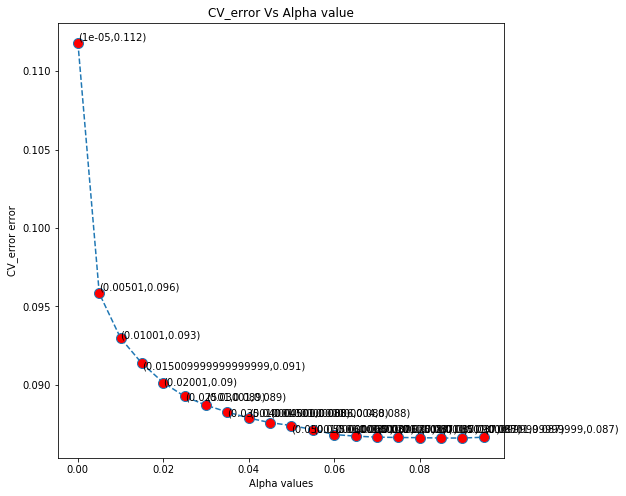

********************************************************************************
Best Score among all the alpha values is: 0.9133942857142857
Grid_best_params: {'alpha': 0.08501}
Grid_best_estimator: MultinomialNB(alpha=0.08501, class_prior=None, fit_prior=True)
Optimal Value for alpha is: 0.08501
****************************************************************************************************

The accuracy score of the Naive Classifier on Test Data for alpha = 0.085010 is 0.913707
****************************************************************************************************
Confusion Matrix for the  Tf_idf :
 [[ 5479  5608]
 [  864 63049]]
****************************************************************************************************
Plotting the Confusion Matrix:


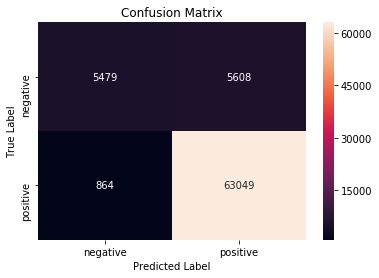

****************************************************************************************************

 The Clasification report for MultinomialNB  algorithm with alpha = 0.08501  is 
               precision    recall  f1-score   support

   negative       0.86      0.49      0.63     11087
   positive       0.92      0.99      0.95     63913

avg / total       0.91      0.91      0.90     75000

Feature Importance for the  Tf-Idf


In [508]:
#Optimal value for Brute Force K-NN:
optimal_alpha = Naive_Bayes_GridSearchCV(X_train_tfidf, y_train)
print('Optimal Value for alpha is:' , optimal_alpha)

print('*'*100)

#Plotting the Confusion matrix for the predicted and actual values to check the accuracy of our model:
#The Naive_Bayes_optimal_confusion_matrix_plot function takes 5 arguments as follows:
#<X_train , y_train , X_test , optimal_value_of_alpha , type_of_vector>
#This method finds the average accuracy score of Naive Bayes model on our test data set.
#This method also computes the final Confusion Matrix which determines the performance of our model.
#We have calculated the classification report for the classifier Naive Bayes.
Naive_Bayes_optimal_confusion_matrix_plot(X_train_tfidf , y_train ,X_test_tfidf , optimal_alpha ,'Tf_idf')

#Calculating the top_10_features for the positive reviews and negative reviews:
pos_features , neg_features = top_10_features(optimal_alpha , tfidf_vector ,X_train_tfidf,  'Tf-Idf')

In [509]:
print("Top 10 positive words with high probability")
pos_features

Top 10 positive words with high probability


love      -6.035315
great     -6.038516
tea       -6.102785
good      -6.110036
tast      -6.129824
like      -6.135853
flavor    -6.202008
coffe     -6.223592
product   -6.267301
use       -6.272929
Name: 1, dtype: float64

In [510]:
print('*'*80)
print("Top 10 negative words with high probability")
neg_features

********************************************************************************
Top 10 negative words with high probability


tast      -6.345595
product   -6.491137
like      -6.504275
would     -6.830566
one       -6.852677
flavor    -6.887511
order     -6.949360
buy       -6.961424
coffe     -6.983629
tri       -6.994169
Name: 0, dtype: float64

# OBSERVATION(Tf-IDF):

##### 1)  In this case of TFIDF vector using the GRIDSEARCHCV() we got the best_parameter i.e alpha value = 0.08501 and the best accuracy score on Cross Validation data as 0.9133942857142857 . We computed the accuracy score on Test Data as 0.913707 which is little more than the accuracy of our model.

##### 2) From the confusion matrix let's define the TP , TN , FP , FN:
#####     Here TP = 63049 which means 63049 predicted positive reviews  we correctly classified as positive.
#####     TN = 5479, FN = 864 , FP = 5608
##### 3) Classification Rate/Accuracy:
###### Accuracy = (TP + TN) / (TP + TN + FP + FN)=(63049+5479/(63049+5479+864+5608)) = 0.91339 , which is equal to our accuracy of our classifier as stated above.

###### Recall: Recall gives us an idea about when it’s actually yes, how often does it predict yes.
###### Recall=TP / (TP + FN)=0.91

###### Precision: Precsion tells us about when it predicts yes, how often is it correct.
###### Precision = TP / (TP + FP)=0.91

###### High recall, low precision: This means that most of the positive examples are correctly recognized (low FN) but there are a lot of false positives.
#####  Low recall, high precision: This shows that we miss a lot of positive examples (high FN) but those we predict as positive are indeed positive (low FP).

##### TPR : TPR is equal to the precision value so TPR = 0.91
##### TNR : TNR = TN/(TN + FP) = 5479/(5479+5608) = 0.49
##### FPR : FPR = FP/(FP+TN) = 5608/(5608+5479) = 0.50
##### FNR : FNR = FN/(TP+FN) = 864/(864+63049) = 0.013

##### We get low values of FPR and FNR relatively so our model is sensible in case of tf-idf vector.

# CONCLUSIONS:

#### 1. Both Bow and Tf-Idf representations and classifier associated with them have almost same accuracy. 
#### 2. We have assume two things here while trainning our model :
#####     a) Relative ordering of the words does not make much difference.
#####     b) Features in case of Bow , tf-Idf are conditionally independent of each other. 
##### These assumptions reduces the complexities in computing the likelihoods.

#### 3. Naive Bayes is very fast trainning model as compared to the KNN Model.
#### 4. Naive Bayes assumes features are independent of each other whereas in W2V features are so much dependent so using the 
####     naive bayes with W2Vec is not the good idea here. 